In [1]:
import datetime as dt
import os
import requests
import time
from urllib import parse
from glob import glob

import pandas as pd
from bs4 import BeautifulSoup
# from selenium import webdriver
# from selenium.webdriver.common.keys import Keys
# from selenium.webdriver.common.by import By
from tqdm.notebook import tqdm, trange
from markdownify import markdownify as md


base_url = "https://namu.wiki"
logging_dir = "/home/nsw/datasets/namuwiki_scrapping_logs/"

# beautifulsoup

## graph

In [31]:
step = len(glob(logging_dir + ".xlsx"))
log_cols = ["parents", "key", "use"]
graph = dict()

In [32]:
if not os.path.isfile(logging_dir + "result_step_00.xlsx"):
    pd.DataFrame([("root", "우왁굳", 1)], columns=log_cols).to_excel(logging_dir + f"result_step_{step:02d}.xlsx", index=None)

In [27]:
def make_node(title: str, children: list):
    return {
        "title": title,
        "url": parse.quote(base_url + title),
        "children": [ch[1] for ch in children],
    }

In [45]:
key_df = pd.read_excel(logging_dir + f"result_step_{step:02d}.xlsx")
for _, row in key_df.iterrows():
    if pd.isna(row['use']):
        graph[row['parents']]['children'].remove(row['key'])

keys = key_df.dropna().key.to_list()

# keys = pd.read_excel(logging_dir + f"result_step_{step:02d}.xlsx").key.dropna().to_list()
step += 1
new_keys = []
for key in tqdm(keys):
    if key in graph:
        # print(key, ": continue")
        continue
    soup = BeautifulSoup(requests.get(base_url + key).text, 'html.parser')

    index = soup.select_one("div.toc-indent")
    if index == None:
        children = []
    else:
        children = [
            (key, parse.unquote(link.get_attribute_list("href")[0].split("/", 2)[-1]), 1)
            for link in index.select("a.wiki-link-internal")
        ]

    node = make_node(key, children)
    graph[key] = node
    # print(key, children)

    new_keys += children

# new_keys
pd.DataFrame(new_keys, columns=log_cols).to_excel(logging_dir + f"result_step_{step:02d}.xlsx", index=None)

  0%|          | 0/101 [00:00<?, ?it/s]

In [25]:
graph.keys()

dict_keys(['우왁굳', '우왁굳/방송 역사', '왁두', '우왁굳/특징', '우왁굳/별명 및 밈', '우왁굳/콘텐츠', '우왁굳/플레이한 게임', '침팬치', '왁물원', '우왁굳TV', '왁카데미', '우왁굳/콘텐츠/고정 멤버', '이세계아이돌', '왁타버스 중간계', '우왁굳/논란 및 사건 사고', '우왁굳/어록', '오뱅계르크', '우왁굳/연도별 행적', '아프리카TV', '왁두/파생형', '우왁굳/콘텐츠/게임', '우왁굳/콘텐츠/비게임', '왁타버스', '고멤 놀이터', '왁물원/이세계아이돌 게시판', '왁물원/인력사무소', '우왁굳/콘텐츠/비게임/연말 공모전', '왁물원/규정', '네이버 카페', '왁물원/역사', '개복어', '노돌리', '레알마틴', '렘쨩', '로복', '무결', '조마문', '조매력', '천양', '크헐헐', '도그홀', '두칠', '바나나(인터넷 방송인)', '진호(인터넷 방송인)', '함군', '겜스터', '휘용', '고니잠', '주르르', '우왁굳/콘텐츠/고정 멤버/0기', '왁타버스 고정 멤버', '고멤 아카데미', '이세계아이돌/멤버 간 케미', '이세계아이돌/오디션', '이세계아이돌/활동', '이세계아이돌/공연 및 행사', '이세계아이돌/음반 목록', '이세계아이돌/오리지널 곡', '이세계아이돌/커버 곡', '마법소녀 이세계아이돌', '차원을 넘어 이세계아이돌', '이파리', '이세계아이돌/응원법', '이세계아이돌/굿즈', '이세계아이돌/이모티콘', '이세계아이돌/월드', '이세계아이돌/여담', '2020년 유튜버 뒷광고 사건'])

In [30]:
graph['우왁굳/논란 및 사건 사고']['children']

[('우왁굳/논란 및 사건 사고', 'One Hour One Life'),
 ('우왁굳/논란 및 사건 사고', '그리핑'),
 ('우왁굳/논란 및 사건 사고', '2020년 유튜버 뒷광고 사건'),
 ('우왁굳/논란 및 사건 사고', '왁타버스')]

## Tree  

In [18]:
def make_tree_node(
    title: str, 
    parents: str, 
    subcategory: list, 
    subdocs: list, 
    subform: list
):
    return {
        "title": title,
        "url": base_url + parse.quote("/w/분류:" + title),
        "parents": parents,
        "subcategory": subcategory,
        "subdocs": subdocs,
        "subform": subform,
    }

In [19]:
tree = {}
next_keys = [("root", "우왁굳")]

while len(next_keys) > 0:
    keys = next_keys
    next_keys = []

    for parents, key in tqdm(keys, leave=False):
        if key in tree:
            continue
        soup = BeautifulSoup(requests.get(base_url + "/w/분류:" + key).text, 'html.parser')

        subcategory = soup.select_one("#category-분류")
        subdocs = soup.select_one("#category-문서")
        subform = soup.select_one("#category-틀")
        
        subcategory = [] if subcategory is None else [tag.get_attribute_list("title")[0].split(":", 1)[-1] for tag in subcategory.select("a")]
        subdocs = [] if subdocs is None else [tag.get_attribute_list("title")[0] for tag in subdocs.select("a")]
        subform = [] if subform is None else [tag.get_attribute_list("title")[0].split(":", 1)[-1] for tag in subform.select("a")]

        node = make_tree_node(key, parents, subcategory, subdocs, subform)
        tree[key] = node
        # print(key, children)
    
        next_keys += [(key, sc) for sc in subcategory]

    print(next_keys)

  0%|          | 0/1 [00:00<?, ?it/s]

[('우왁굳', '왁물원'), ('우왁굳', '우왁굳/밈'), ('우왁굳', '우왁굳/콘텐츠'), ('우왁굳', '파일/우왁굳')]


  0%|          | 0/4 [00:00<?, ?it/s]

[('우왁굳/콘텐츠', '왁타버스'), ('우왁굳/콘텐츠', '우왁굳/콘텐츠/게임'), ('우왁굳/콘텐츠', '우왁굳/콘텐츠/고정 멤버'), ('파일/우왁굳', '파일/고멤 가요제'), ('파일/우왁굳', '파일/왁타버스')]


  0%|          | 0/5 [00:00<?, ?it/s]

[('왁타버스', '2023 왁타버스 뮤직 어워즈'), ('왁타버스', '고멤 가요제'), ('왁타버스', '고멤 아카데미'), ('왁타버스', '왁타버스 고정 멤버'), ('왁타버스', '왁타버스 관련 VR챗 월드'), ('왁타버스', '왁타버스 작곡캠프'), ('왁타버스', '왁타버스/오리지널 곡'), ('왁타버스', '이세계아이돌'), ('왁타버스', '파일/왁타버스'), ('우왁굳/콘텐츠/게임', '우왁굳/콘텐츠/게임/VR챗'), ('우왁굳/콘텐츠/게임', '티바로살래나'), ('우왁굳/콘텐츠/고정 멤버', '고멤 아카데미'), ('우왁굳/콘텐츠/고정 멤버', '왁타버스 고정 멤버'), ('파일/왁타버스', '파일/고멤 아카데미'), ('파일/왁타버스', '파일/왁타버스 고정 멤버'), ('파일/왁타버스', '파일/이세계아이돌')]


  0%|          | 0/16 [00:00<?, ?it/s]

[('고멤 가요제', '고멤 가요제/노래'), ('고멤 가요제', '고멤 가요제/팀'), ('고멤 가요제', '파일/고멤 가요제'), ('고멤 아카데미', '고멤 아카데미/소속 멤버'), ('고멤 아카데미', '고멤 아카데미/오리지널 곡'), ('고멤 아카데미', '파일/고멤 아카데미'), ('왁타버스 고정 멤버', '왁타버스 고정 멤버/소속 멤버'), ('왁타버스 고정 멤버', '왁타버스 고정 멤버/시즌'), ('왁타버스 고정 멤버', '왁타버스 고정 멤버/오리지널 곡'), ('왁타버스 고정 멤버', '파일/왁타버스 고정 멤버'), ('왁타버스/오리지널 곡', '고멤 아카데미/오리지널 곡'), ('왁타버스/오리지널 곡', '왁타버스 고정 멤버/오리지널 곡'), ('왁타버스/오리지널 곡', '이세계아이돌/오리지널 곡'), ('이세계아이돌', '이세계아이돌/2차 창작'), ('이세계아이돌', '고세구'), ('이세계아이돌', '이세계아이돌/공연 및 행사'), ('이세계아이돌', '둘러보기 틀/이세계아이돌'), ('이세계아이돌', '릴파'), ('이세계아이돌', '마법소녀 이세계아이돌'), ('이세계아이돌', '비챤'), ('이세계아이돌', '아이네'), ('이세계아이돌', '이세계아이돌/오리지널 곡'), ('이세계아이돌', '이세계아이돌/음반'), ('이세계아이돌', '이파리'), ('이세계아이돌', '주르르'), ('이세계아이돌', '징버거'), ('이세계아이돌', '차원을 넘어 이세계아이돌'), ('이세계아이돌', '파일/이세계아이돌'), ('우왁굳/콘텐츠/게임/VR챗', '2023 왁타버스 뮤직 어워즈'), ('우왁굳/콘텐츠/게임/VR챗', '고멤 가요제'), ('파일/이세계아이돌', '파일/고세구'), ('파일/이세계아이돌', '파일/릴파'), ('파일/이세계아이돌', '파일/비챤'), ('파일/이세계아이돌', '파일/아이네'), ('파일/이세계아이돌', '파일/주르르'), ('파일/이세계아이돌', '파일/징버거')]


  0%|          | 0/36 [00:00<?, ?it/s]

[('왁타버스 고정 멤버/오리지널 곡', '고멤 가요제/노래'), ('고세구', 'TOUR'), ('고세구', '파일/고세구'), ('이세계아이돌/공연 및 행사', 'TOUR'), ('릴파', '파일/릴파'), ('마법소녀 이세계아이돌', '마법소녀 이세계아이돌/등장인물'), ('비챤', '파일/비챤'), ('아이네', '파일/아이네'), ('주르르', '파일/주르르'), ('징버거', '파일/징버거'), ('차원을 넘어 이세계아이돌', '차원을 넘어 이세계아이돌/등장인물')]


  0%|          | 0/11 [00:00<?, ?it/s]

[]


In [20]:
len(tree)

53

## scrappping

In [9]:
def set_a_href(tag):
    for a_tag in tag.select("a"):
        if a_tag.get("href") is not None and not a_tag['href'].startswith("#"):
            a_tag['href'] = parse.unquote(a_tag['href']).replace(" ", "%20")
    
    # wiki-fn-content # 주석
    for a_tag in tag.select("a.wiki-fn-content"):
        # print(a_tag.get("href", "#")[1:])
        footnote_text = footnote_dict.get(a_tag.get("href", "#")[1:])
        if footnote_text is not None:
            a_tag['title'] = footnote_text
        # print(a_tag, "\n")
        
    # wiki-link-external # 외부링크
    # pass
    
    # wiki-link-internal # 내부링크
    for a_tag in tag.select("a.wiki-link-internal"):
        if (
            a_tag.get("href") is not None 
            and not a_tag['href'].startswith(base_url)
        ):
            if not a_tag['href'].startswith("#"):
                a_tag['href'] = base_url + a_tag['href']
            else:
                # print(a_tag['href'])
                pass

    
    return tag

In [15]:
def scrap(title: str):
    url = base_url + "/w/" + title
    soup = BeautifulSoup(requests.get(url).text, 'html.parser')

    # footnote
    footnote_dict = {
        elm.select_one("span").get("id"): md(str(set_a_href(elm)))
        for i, elm in enumerate(soup.select('.footnote-list'))
    }

    # head, content
    heads = [set_a_href(head) for head in soup.select('.wiki-heading')]
    contents = [set_a_href(content) for content in soup.select('.wiki-heading-content')]

    docs = [
        md(str(set_a_href(h))) + "\n" + md(str(set_a_href(c))) + "\n"
        for h, c in zip(heads, contents)
    ]

    return docs

In [26]:
tree['우왁굳']

{'title': '우왁굳',
 'url': 'https://namu.wiki/w/%EB%B6%84%EB%A5%98%3A%EC%9A%B0%EC%99%81%EA%B5%B3',
 'parents': 'root',
 'subcategory': ['왁물원', '우왁굳/밈', '우왁굳/콘텐츠', '파일/우왁굳'],
 'subdocs': ['Hush(우왁굳)',
  '겜스터',
  '오히려',
  '왁제이맥스/수록곡',
  '왁제이맥스/업데이트 내역',
  '왁컬로이드',
  '왁타버스 중간계',
  '우왁굳',
  '우왁굳 마이너 갤러리',
  '우왁굳/논란 및 사건 사고',
  '우왁굳/방송 역사',
  '우왁굳/어록',
  '우왁굳/연도별 행적',
  '우왁굳/연도별 행적/2022년',
  '우왁굳/연도별 행적/2023년',
  '우왁굳/특징',
  '우왁굳/플레이한 게임',
  '우왁굳TV',
  '우왁굳의 고집',
  '우왁굳의 고집/아이템',
  '우왁굳즈',
  '융터르',
  '침팬치'],
 'subform': ['우왁굳', '우왁굳TV']}

In [28]:
docs = []
subdocs = ['우왁굳']

while len(subdocs) > 0:
    new_subdocs = []
    for key in subdocs:
        print(key)
        docs += tree[key]['subdocs']
        new_subdocs += tree[key]['subcategory']
    print(new_subdocs, "\n")
    subdocs = new_subdocs

우왁굳
['왁물원', '우왁굳/밈', '우왁굳/콘텐츠', '파일/우왁굳'] 

왁물원
우왁굳/밈
우왁굳/콘텐츠
파일/우왁굳
['왁타버스', '우왁굳/콘텐츠/게임', '우왁굳/콘텐츠/고정 멤버', '파일/고멤 가요제', '파일/왁타버스'] 

왁타버스
우왁굳/콘텐츠/게임
우왁굳/콘텐츠/고정 멤버
파일/고멤 가요제
파일/왁타버스
['2023 왁타버스 뮤직 어워즈', '고멤 가요제', '고멤 아카데미', '왁타버스 고정 멤버', '왁타버스 관련 VR챗 월드', '왁타버스 작곡캠프', '왁타버스/오리지널 곡', '이세계아이돌', '파일/왁타버스', '우왁굳/콘텐츠/게임/VR챗', '티바로살래나', '고멤 아카데미', '왁타버스 고정 멤버', '파일/고멤 아카데미', '파일/왁타버스 고정 멤버', '파일/이세계아이돌'] 

2023 왁타버스 뮤직 어워즈
고멤 가요제
고멤 아카데미
왁타버스 고정 멤버
왁타버스 관련 VR챗 월드
왁타버스 작곡캠프
왁타버스/오리지널 곡
이세계아이돌
파일/왁타버스
우왁굳/콘텐츠/게임/VR챗
티바로살래나
고멤 아카데미
왁타버스 고정 멤버
파일/고멤 아카데미
파일/왁타버스 고정 멤버
파일/이세계아이돌
['고멤 가요제/노래', '고멤 가요제/팀', '파일/고멤 가요제', '고멤 아카데미/소속 멤버', '고멤 아카데미/오리지널 곡', '파일/고멤 아카데미', '왁타버스 고정 멤버/소속 멤버', '왁타버스 고정 멤버/시즌', '왁타버스 고정 멤버/오리지널 곡', '파일/왁타버스 고정 멤버', '고멤 아카데미/오리지널 곡', '왁타버스 고정 멤버/오리지널 곡', '이세계아이돌/오리지널 곡', '이세계아이돌/2차 창작', '고세구', '이세계아이돌/공연 및 행사', '둘러보기 틀/이세계아이돌', '릴파', '마법소녀 이세계아이돌', '비챤', '아이네', '이세계아이돌/오리지널 곡', '이세계아이돌/음반', '이파리', '주르르', '징버거', '차원을 넘어 이세계아이돌', '파일/이세계아이돌', '파일/고멤 아카데미', '파일/왁타버스 고정 멤버', '

## test

In [5]:
soup = BeautifulSoup(requests.get(base_url + "/w/" + '아이네').text, 'html.parser')
# soup.select('body')

### footnote list

In [6]:
from markdownify import markdownify as md

footnote_list = soup.select('.footnote-list')

footnote_dict = {
    elm.select_one("span").get("id"): md(str(set_a_href(elm)))
    for i, elm in enumerate(footnote_list)
}

### head, content

In [7]:
head = soup.select('.wiki-heading')
content = soup.select('.wiki-heading-content')
print(len(head), len(content))

32 32


In [11]:
from markdownify import markdownify as md

i = 21

# for i in range(len(head)):
#     head[i] = set_a_href(head[i])
#     content[i] = set_a_href(content[i])
head[i] = set_a_href(head[i])
content[i] = set_a_href(content[i])

print(md(str(head[i])))
print(md(str(content[i])))

# print("\n", "=" * 50, "\n")

# print(head[i], "\n")
# print(content[i])


### [8.1.](#toc) 사생활 관련[[편집]](/edit/우왁굳?section=22)


* 어릴 적에 [재믹스](https://namu.wiki/w/재믹스(게임기) "재믹스(게임기)")와 [슈퍼 패미컴](https://namu.wiki/w/슈퍼%20패미컴 "슈퍼 패미컴")을 소유하고 있었다고 한다.

* 2018년 3월 방송 중 시청자들에게 부모님 집 대출금을 자신이 오늘 다 갚았다며 어머니가 좋아하셨다며 시청자들에게 감사를 표했다.

* MBTI 검사를 여러 번 받았으며 매번 다른 결과가 나왔다고 한다. 내향 척도는 늘 변하지 않았다고.

* 자동차를 좋아하며 그 중에서도 [BMW](https://namu.wiki/w/BMW "BMW")를 열렬히 좋아한다. BMW 코리아 25주년 기념으로 출시된 BMW M340i 페리도트 그린 에디션을 소유하고 있다고 밝혔다. 자동차에 관해서 다양한 지식이 있으나 자신이 좋아하는 자동차 브랜드에만 관심이 있어서 [포르쉐 919](https://namu.wiki/w/포르쉐%20919%20하이브리드 "포르쉐 919 하이브리드")를 [911](https://namu.wiki/w/포르쉐%20911 "포르쉐 911")이라고 부르거나, [아우디 스포트 콰트로](https://namu.wiki/w/아우디%20스포트%20콰트로 "아우디 스포트 콰트로")[[66]](#fn-66 "[[66]](#rfn-66) 랠리 경기에 사륜구동을 정착시키고, [그룹 B](https://namu.wiki/w/그룹%20B \"그룹 B\")의 초창기를 휩쓴 전설적인 레이스카.")에 대한 지식이 얕다.

* [이니셜D](https://namu.wiki/w/이니셜D "이니셜D") 한정 씹덕이라고 한다. [[67]](#fn-67 "[[67]](#rfn-67) 그렇게 주장했으나 정작 Fifth/Final/Extra Stage의 존재는 2024년 2월까지도 모르고 있었다. ")

* 피곤할 때 잠들면 해괴한 신음을 내는 버릇이 있다. 그래서 엔젤의 왁트모르즈비 

In [8]:
text = ""

for h, c in zip(head, content):
    h = set_a_href(h)
    c = set_a_href(c)
    text += md(str(h)) + "\n"
    text += md(str(c)) + "\n"


with open("test.md", "w", encoding="utf-8") as f:
    f.write(text)

KeyError: 'href'

### table

In [13]:
tables = soup.select("table.wiki-table")
print(md(str(tables[4])))



|  |
| --- |
| **우왁굳 관련 둘러보기 틀** |
|  [ 펼치기 · 접기 ]

---



|  |
| --- |
| [패러블 엔터테인먼트 로고 화이...](/w/%ED%8C%A8%EB%9F%AC%EB%B8%94%20%EC%97%94%ED%84%B0%ED%85%8C%EC%9D%B8%EB%A8%BC%ED%8A%B8 "패러블 엔터테인먼트") |
|  [ 펼치기 · 접기 ]

|  |
| --- |
| **엔터테이너** |
| [김수현](/w/%EA%B9%80%EC%88%98%ED%98%84(%EB%B0%A9%EC%86%A1%EC%9D%B8) "김수현(방송인)") | [김효진](/w/%EA%B9%80%ED%9A%A8%EC%A7%84(%EB%B0%A9%EC%86%A1%EC%9D%B8) "김효진(방송인)") | [조매력](/w/%EC%A1%B0%EB%A7%A4%EB%A0%A5 "조매력") |
| **크리에이터** |
| 

|  |  |  |  |  |
| --- | --- | --- | --- | --- |
| [369랑께](/w/369%EB%9E%91%EA%BB%98 "369랑께") | [9호](/w/9%ED%98%B8(%EC%9D%B8%ED%84%B0%EB%84%B7%20%EB%B0%A9%EC%86%A1%EC%9D%B8) "9호(인터넷 방송인)") | [개복어](/w/%EA%B0%9C%EB%B3%B5%EC%96%B4 "개복어") | [갱복치](/w/%EA%B0%B1%EB%B3%B5%EC%B9%98 "갱복치") |  [경식이할아버지](/w/%EA%B2%BD%EC%8B%9D%EC%9D%B4%ED%95%A0%EC%95%84%EB%B2%84%EC%A7%80 "경식이할아버지") |
| [고먐잉](/w/%EA%B3%A0%EB%A8%90%EC%9E%89 "고먐잉") | 고유사 | 기령 | 기사단 | [김길현](/w/%EA%B9%80%EA%B8%B8%ED%98%84 "김길현") |
| [김반희](/w/%EA%B9%80%EB%B0%98%ED%9D%AC "김반희"

## draw graph

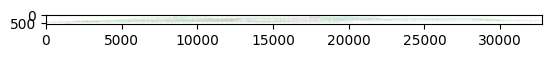

In [25]:
import pydot
import matplotlib.pyplot as plt
import matplotlib.image as img

graph = pydot.Dot(graph_type='graph', charset="UTF-8", fontname="malgun")

for node in tree.values():
    for sub in node['subcategory']:
        graph.add_edge(pydot.Edge(node['title'], sub, color="blue"))
    for sub in node['subdocs']:
        graph.add_edge(pydot.Edge(node['title'], sub, color="green"))
    for sub in node['subform']:
        graph.add_edge(pydot.Edge(node['title'], sub, color="red"))

graph.write_png('./graph.png')

img_test = img.imread('./graph.png')
plt.imshow(img_test)
plt.show()